# Practical 4 Part 2 - Training Our Segmentation Model on Colab

**Open this Notebook in Google's Colab (https://colab.research.google.com)**

The next step is for us to train our segmentation model using the data that we've processed in Part A. 

In this part, we will be using the open source segmentation models created by qubvel on Github. The latest codes can be found at:
   
> https://github.com/qubvel/segmentation_models

Running the code block below in this notebook will allow you to install the code.


## 4.2.1 Mounting Our Google Drive

First, let's mount our Google Drive containing the *.npy files.

In [1]:
# Run this if you are using Google Drive
#
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## 4.2.2 Listing Files in Our Google Drive

Run the following to list the files in your Data/D4 folder on Google Drive.

If you haven't already uploaded your files to Google Drive, please upload the "x" and "y" folders generated from Part 1 into the Data/D4 folder


In [2]:
!ls /content/drive/My\ Drive/Data/D4 

x  y


## 4.2.3 Install Keras Segmentation Models

Run the following cell to install the keras segmentation models in our Colab environment. 

*NOTE: When this Colab environment is disconnected and restarted, you may have to run this again!*


In [3]:
!pip install git+https://github.com/qubvel/segmentation_models

  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-ifzne8pe
  Running command git clone -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-ifzne8pe
  Running command git submodule update --init --recursive -q
  Created wheel for segmentation-models: filename=segmentation_models-1.0.1-cp36-none-any.whl size=33587 sha256=a8d4c788203fe4b089aace2741eee508aefeafabd0d177e4ca954d662fbb7863
  Stored in directory: /tmp/pip-ephem-wheel-cache-41y36cxu/wheels/49/cf/46/cbb4bb64518c402aea99df9d466f1081450597e653256bbcf4
Successfully built segmentation-models


## 4.2.4 Import All Necessary Libraries

Run the following cell to import all necessary libraries.


In [4]:

import numpy as np
import segmentation_models as sm
import os
from tensorflow import keras
from sklearn.model_selection import train_test_split
from segmentation_models.utils import set_trainable
from datetime import datetime


Using TensorFlow backend.


Segmentation Models: using `keras` framework.


## 4.2.5 Declaring Our Data Batch Generator

Run the following cell to declare our Data Generator class.


In [0]:
# The DataGenerator class is a Sequence class used by Keras
# to load data in batches during training
# 
# See https://keras.io/utils/ for more info.
#
class DataGenerator(keras.utils.Sequence):
    
    def __init__(self, x_path, y_path, file_IDs, samples_per_file, batch_size, process_x=None, process_y=None, load_to_memory=True):
        # Initialization
        self.samples_per_file = samples_per_file
        self.batch_size = batch_size
        self.perm_batch_size = batch_size

        self.load_to_memory = False
        self.x_path = x_path
        self.y_path = y_path        
        self.file_IDs = file_IDs

        self.current_loaded_file_ID = -1
        self.current_loaded_x = None
        self.current_loaded_y = None
        
        self.all_x = {}
        self.all_y = {}
        
        self.process_x = process_x
        self.process_y = process_y

        self.on_epoch_end()

        # Check for the presence of the files,
        # and remove those batch IDs that doesn't exist.
        #
        self.file_IDs = []
        
        
        for i in range(0, len(file_IDs)):
            ID = file_IDs[i]
            if os.path.exists(self.x_path + ("/%d" % ID) + '.npy') and os.path.exists(self.y_path + ("/%d" % ID) + '.npy'):
                self.file_IDs.append(file_IDs[i])
            else:
                print ("File path: %s or %s not found" % (self.x_path + ("/%d" % ID) + '.npy', self.y_path + ("/%d" % ID) + '.npy'))
        print (self.file_IDs)
        print ("Total of %d files" % (len(self.file_IDs)))

        if (load_to_memory):
            for i, ID in enumerate(self.file_IDs):
                # Load input and output all into memory
                # This should only be used if your computer's memory 
                # is sufficient to hold all the data from training.
                # 
                self.all_x[ID], self.all_y[ID] = self.load_file(ID)

                if (i % 10 == 0):
                    print ("Loading file into memory (%d out of %d)" % (i, len(self.file_IDs)))

            self.load_to_memory = True

            print ("Loading files into memory complete.")

    # Returns the number of batches per epoch
    #
    def __len__(self):
        return int(len(self.file_IDs) * self.samples_per_file / self.batch_size)


    # Generates data containing batch_size samples.
    # This is called by Keras during training to retrieve
    # the set of data for each batch.
    #    
    def __getitem__(self, index):
        x = []
        y = []

        sample_number = index * self.batch_size

        which_file = int(sample_number / self.samples_per_file)
        which_position_in_file = sample_number % self.samples_per_file

        #print ("  index: %d file: %d pos: %d" % (index, which_file, which_position_in_file))

        ID = self.file_IDs[which_file]
        fx, fy = self.load_file(ID)

        # Load data
        for i in range(0, self.batch_size):
            
            if which_position_in_file < len(fx) and which_position_in_file < len(fy):
                x.append(fx[which_position_in_file])
                y.append(fy[which_position_in_file])

            which_position_in_file = which_position_in_file + 1

            if which_position_in_file >= self.samples_per_file and i != self.batch_size - 1:
                which_position_in_file = 0
                which_file = which_file + 1

                if which_file >= len(self.file_IDs):
                    break

                ID = self.file_IDs[which_file]
                fx, fy = self.load_file(ID)

        x = np.array(x)
        y = np.array(y)

        # perform any additional processing, if the function
        # is provided.
        #
        if (not self.process_x is None):
            x = self.process_x(x)
        if (not self.process_y is None):
            y = self.process_y(y)

        return x, y

    # Resets indexes after each epoch
    #
    def on_epoch_end(self):
        self.batch_size = self.perm_batch_size
        self.current_loaded_file_ID = -1

    # Load file
    #
    def load_file(self, ID):
        if ID != self.current_loaded_file_ID:
            #print ("getting file ID %d..." % (ID))

            if (self.load_to_memory):
                x = self.all_x[ID]
                y = self.all_y[ID]
            else:
                x = np.load(self.x_path + ("/%d" % ID) + '.npy')
                y = np.load(self.y_path + ("/%d" % ID) + '.npy')

            self.current_loaded_file_ID = ID;
            self.current_loaded_x = x
            self.current_loaded_y = y

        else:
            x = self.current_loaded_x
            y = self.current_loaded_y

        return x, y

    def set_batch_size_to_1(self):
        self.batch_size = 1



## 4.2.6 Load the Processed X and Y Training Data

Copy the following code to the TODO section below to load our data from the folders. We will use file numbers 0 to 15 for the training, and 16 to 19 for the validation. Each file contains 50 samples for training, and we are using 8 samples per batch.

```
train_data = DataGenerator(x_folder, y_folder, range(0, 16), 50, 8, preprocess_input, None, True)
test_data = DataGenerator(x_folder, y_folder, range(16, 20), 50, 8, preprocess_input, None, True)
```

Then, run the following cell to initialize some variables, and load the X and Y training data from our Google Drive.


In [7]:
# Set this to the folder containing your files
#
npy_folder = '/content/drive/My Drive/Data/D4/'
x_folder = npy_folder + "x"
y_folder = npy_folder + "y"

keras.backend.set_image_data_format('channels_last')
sm.set_framework('tf.keras')

# Total number of classes we will predict.
#
num_classes = 4

# Choose the backbone for our segmentation model
#
#   resnet18 / resnet34 / resnet50 / resnet101 / resnext50, resnext101, mobilenet, inceptionv2, inceptionv3
#
# You may have to adjust the input+output dimensions for different backbones.
#
backbone = 'resnet34'   

# Get the preprocessor
preprocess_input = sm.get_preprocessing(backbone)

# Choose the segmentation network
# unet / linknet / pspnet / fpn
#
network = 'unet'   

# Training parameters
#
freeze_encoder_epochs = 50
#unfreeze_encoder_epochs = 100

# TODO:
# Load the training and test data into our batch generator
# NOTE: If you see the allow_pickle error when using Google Drive, just ignore 
#       it, and wait for a few minutes or re-upload the files again. 
#
#...#
train_data = DataGenerator(x_folder, y_folder, range(0, 16), 50, 8, preprocess_input, None, True)
test_data = DataGenerator(x_folder, y_folder, range(16, 20), 50, 8, preprocess_input, None, True)



File path: /content/drive/My Drive/Data/D4/x/5.npy or /content/drive/My Drive/Data/D4/y/5.npy not found
File path: /content/drive/My Drive/Data/D4/x/6.npy or /content/drive/My Drive/Data/D4/y/6.npy not found
File path: /content/drive/My Drive/Data/D4/x/7.npy or /content/drive/My Drive/Data/D4/y/7.npy not found
File path: /content/drive/My Drive/Data/D4/x/8.npy or /content/drive/My Drive/Data/D4/y/8.npy not found
File path: /content/drive/My Drive/Data/D4/x/9.npy or /content/drive/My Drive/Data/D4/y/9.npy not found
[0, 1, 2, 3, 4, 10, 11, 12, 13, 14, 15]
Total of 11 files
Loading file into memory (0 out of 11)
Loading file into memory (10 out of 11)
Loading files into memory complete.
[16, 17, 18, 19]
Total of 4 files
Loading file into memory (0 out of 4)
Loading files into memory complete.


## 4.2.7 Perform the Training

Depending on the model and backbone that you select, training may take 10-20 minutes. 

As the model trains, keep a lookout for the scoring metrics that we have added. Unlike in the normal classification training where use accuracy, in this case we make use of the Intersection-over-Union as the scoring metric to determine how well our model performs. With this set of data and this model configuration, we are likely to see around 60-65% average IoU scores. 

In [8]:
# Create the training folder
#
training_session_id = datetime.now().strftime("%Y-%m-%d %H-%M-%S")
training_session_folder = npy_folder + '/segmentation_train_%s' % (training_session_id)
os.makedirs(training_session_folder, exist_ok=True)


# TODO: 
# Define segmentation model
#
# This code creates the corresponding segmentation network based on the variable declared in the "network" variable.
# define model
#
if network == 'unet':
    # Input width/height must be divisible by 32.
    model = sm.Unet(backbone, input_shape=(288, 192, 3), encoder_weights='imagenet', encoder_freeze=True, classes=num_classes, activation='softmax')
if network == 'fpn':
    # Input width/height must be divisible by 32.
    model = sm.FPN(backbone, input_shape=(288, 192, 3), encoder_weights='imagenet', encoder_freeze=True, classes=num_classes, activation='softmax')
if network == 'pspnet':
    # Input width/height must be divisible by 48.
    model = sm.PSPNet(backbone, input_shape=(288, 192, 3), encoder_weights='imagenet', encoder_freeze=True, classes=num_classes, activation='softmax')
if network == 'linknet':
    # Input width/height must be divisible by 32.
    model = sm.Linknet(backbone, input_shape=(288, 192, 3), encoder_weights='imagenet', encoder_freeze=True, classes=num_classes, activation='softmax')

# Compile model
#
model.compile(
    'Adam',
    loss=sm.losses.categorical_focal_jaccard_loss,
    metrics=[sm.metrics.iou_score, 'accuracy'],
)
model.summary()


# Configure the checkpoint and stop point.
# This allows the training to save the best models and also stop the
# training early if it detects that there are no improvements after
# a long time.
#
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath=training_session_folder + '/seg_' + 
            network + '_' + 
            backbone + '_' + 
            'model.a.{epoch:04d}-acc-{acc:4.2f}-val_acc-{val_acc:4.2f}-{val_iou_score:.2f}-loss-{val_loss:4.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)
]


# pre-train the decoder weights
#
print ("Freeze encoder training...")
history1 = model.fit_generator(train_data, epochs=freeze_encoder_epochs, verbose=True, validation_data=test_data, callbacks=callbacks_list)


'''
# OPTIONAL:
# This section unfreezes the layers in the backbone model and continues on with the training.

# release all layers for training
for layer in model.layers:
    layer.trainable = True


# Compile the model again
#
model.compile(
    'Adam',
    loss=sm.losses.categorical_focal_jaccard_loss,
    metrics=[sm.metrics.iou_score, 'accuracy'],
)

# Configure the checkpoint and stop point.
# This allows the training to save the best models and also stop the
# training early if it detects that there are no improvements after
# a long time.
#
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath=training_session_folder + '/seg_' + 
            network + '_' + 
            backbone + '_' + 
            'model.b.{epoch:04d}-acc-{acc:4.2f}-val_acc-{val_acc:4.2f}-{val_iou_score:.2f}-loss-{val_loss:4.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)
]


# Train model again
#
print ("Unfreeze encoder training...")
history2 = model.fit_generator(train_data, epochs=unfreeze_encoder_epochs, verbose=True, validation_data=test_data, callbacks=callbacks_list)
'''




Instructions for updating:
If using Keras pass *_constraint arguments to layers.
85524480/85521592 [==============================] - 3s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, 288, 192, 3) 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 288, 192, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 294, 198, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 144, 9

'\n# OPTIONAL:\n# This section unfreezes the layers in the backbone model and continues on with the training.\n\n# release all layers for training\nfor layer in model.layers:\n    layer.trainable = True\n\n\n# Compile the model again\n#\nmodel.compile(\n    \'Adam\',\n    loss=sm.losses.categorical_focal_jaccard_loss,\n    metrics=[sm.metrics.iou_score, \'accuracy\'],\n)\n\n# Configure the checkpoint and stop point.\n# This allows the training to save the best models and also stop the\n# training early if it detects that there are no improvements after\n# a long time.\n#\ncallbacks_list = [\n    keras.callbacks.ModelCheckpoint(\n        filepath=training_session_folder + \'/seg_\' + \n            network + \'_\' + \n            backbone + \'_\' + \n            \'model.b.{epoch:04d}-acc-{acc:4.2f}-val_acc-{val_acc:4.2f}-{val_iou_score:.2f}-loss-{val_loss:4.2f}.h5\',\n        monitor=\'val_loss\', save_best_only=True),\n    keras.callbacks.EarlyStopping(monitor=\'val_loss\', patience=30)

## 4.2.8 Loading the Best Model

Once you have finished training, run the following to automatically select the best performing model from the training folder and load it up again for evaluation.

We also duplicate the model into another file name, and save its weights as well so that you can easily retrieve them.

Optionally, you can also save the model (and model weights) into a fixed file name for easy retrieval later. The code to that can be found here:


In [9]:
import glob

# List all the .h5 files generated in your training folder.
#
list_of_files = glob.glob(training_session_folder + '/*')  
list_of_files.sort()
best_model_file = list_of_files[-1]

print ("Best model file:")
print (best_model_file)

# Load up the best model
#
model = keras.models.load_model(best_model_file, 
                                custom_objects={
                                    "focal_loss_plus_jaccard_loss": sm.losses.categorical_focal_jaccard_loss,
                                    "iou_score": sm.metrics.iou_score})

# TODO (Optional):
# Save the model and the model weights into a separate file for easy retrieval.
#
#...#
# And save it into another file.
#
model.save(training_session_folder + "/a_segmentation_model.h5")
 
# Save the weights, too
#
model.save_weights(training_session_folder + "/a_segmentation_weights.h5")


Best model file:
/content/drive/My Drive/Data/D4//segmentation_train_2020-01-22 12-12-44/seg_unet_resnet34_model.a.0035-acc-0.99-val_acc-0.94-0.63-loss-0.40.h5
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


## 4.2.9 Evaluate Your Model Performance

Run the following cells to display the training history, confusion matrix and the performance summary. If you are not satisfied with the performance, tune your parameters and retrain until you are satisfied.

Once you are done, proceed to Part 3.

*NOTE: We excluded the "background" label from the confusion matrix because there are significantly more background pixels.*


In [0]:
labels = ["background", "top", "bottom", "one-piece"]


Backbone-frozen training


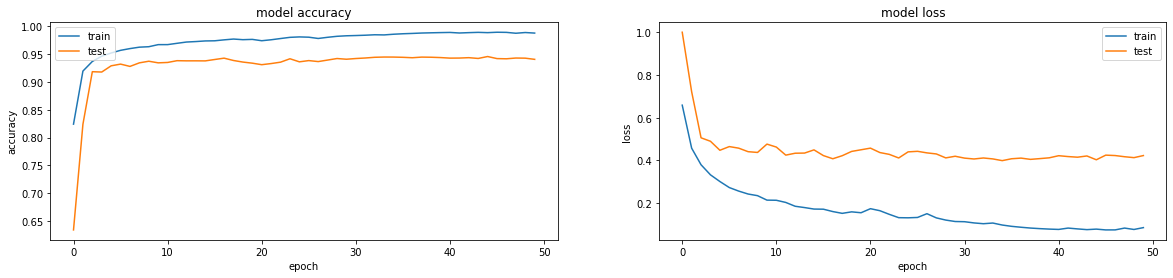

(550, 288, 192, 3)
(550, 288, 192, 4)
(550, 288, 192, 4)
(30412800,)
(30412800,)


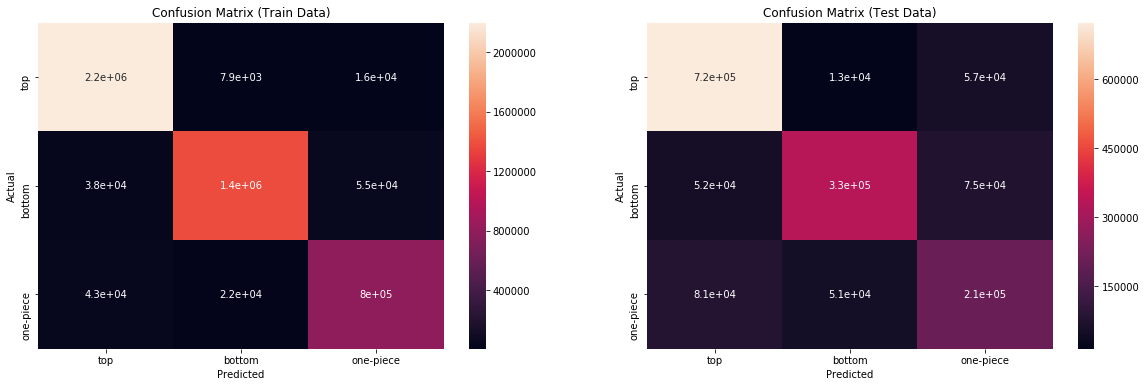

Train Data:
--------------------------------------------------------
              precision    recall  f1-score   support

  background       0.99      0.99      0.99  25694058
         top       0.93      0.92      0.93   2378051
      bottom       0.89      0.96      0.92   1446177
   one-piece       0.87      0.89      0.88    894514

    accuracy                           0.98  30412800
   macro avg       0.92      0.94      0.93  30412800
weighted avg       0.98      0.98      0.98  30412800


Test Data:
--------------------------------------------------------
              precision    recall  f1-score   support

  background       0.99      0.98      0.98   9351285
         top       0.82      0.78      0.80    928250
      bottom       0.66      0.78      0.72    427116
   one-piece       0.55      0.59      0.57    352549

    accuracy                           0.94  11059200
   macro avg       0.75      0.78      0.77  11059200
weighted avg       0.95      0.94      0.95  11

In [14]:
#------------------------------------------------------------------------------------------

import matplotlib.pyplot as plt

# This function is used to display the history the train/test accuracy/loss
# of the Keras training.
#
#   history - Pass in the history returned from the model.fit(...) method.
#
def display_training_loss_and_accuracy(history):
    
    plt.figure(figsize=(20,4))
    
    # summarize history for accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    
    # summarize history for loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()    

print ("Backbone-frozen training")
display_training_loss_and_accuracy(history1)

# print ("Backbone-unfrozen training")
# display_training_loss_and_accuracy(history2)

#------------------------------------------------------------------------------------------

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce

def display_classification_confusion_matrix(keras_model, train_generator, test_generator, labels, mask=None):
    
    x_train = []
    x_test = []
    y_train = []
    y_test = []
    actual_y_train = []
    actual_y_test = []

    train_generator.on_epoch_end()
    train_generator.set_batch_size_to_1()
    for i in range(0, train_generator.__len__()):
        x, y = train_generator.__getitem__(i);

        for n in range(0, x.shape[0]):
            x_train.append(x[n])
            y_train.append(y[n])
            actual_y_train.append(keras_model.predict(x)[n])

    x_train = np.array(x_train)
    y_train = np.array(y_train)
    actual_y_train = np.array(actual_y_train)

    train_generator.on_epoch_end()

    print (x_train.shape)
    print (y_train.shape)
    print (actual_y_train.shape)

    test_generator.on_epoch_end()
    test_generator.set_batch_size_to_1()
    for i in range(0, test_generator.__len__()):
        x, y = test_generator.__getitem__(i);

        for n in range(0, x.shape[0]):
            x_test.append(x[n])
            y_test.append(y[n])
            actual_y_test.append(keras_model.predict(x)[n])

    x_test = np.array(x_test)
    y_test = np.array(y_test)
    actual_y_test = np.array(actual_y_test)

    test_generator.on_epoch_end()

    plt.figure(figsize=(20,6))  

    labels = np.array(labels)
    if mask is not None:
        labels_masked = labels[mask]
    else:
        labels_masked = labels

    # Convert the target labels into the categorical index
    #
    y_train_index = y_train.argmax(axis=len(y_train.shape)-1).flatten()
    actual_y_train_index = actual_y_train.argmax(axis=len(y_train.shape)-1).flatten()
    y_test_index = y_test.argmax(axis=len(y_train.shape)-1).flatten()
    actual_y_test_index = actual_y_test.argmax(axis=len(y_train.shape)-1).flatten()

    print (y_train_index.shape)
    print (actual_y_train_index.shape)
    
    # Print the first Confusion Matrix for the training data
    #
    cm = confusion_matrix(y_train_index, actual_y_train_index)
    if mask is not None:
        cm = cm[:, mask][mask, :]

    cm_df = pd.DataFrame(cm, labels_masked, labels_masked)          
    plt.subplot(1, 2, 1)
    plt.title('Confusion Matrix (Train Data)')
    sns.heatmap(cm_df, annot=True)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')        
    
    # Print the second Confusion Matrix for the test data
    #    
    cm = confusion_matrix(y_test_index, actual_y_test_index)
    if mask is not None:
        cm = cm[:, mask][mask, :]
    
    cm_df = pd.DataFrame(cm, labels_masked, labels_masked)          
    plt.subplot(1, 2, 2)
    plt.title('Confusion Matrix (Test Data)')
    sns.heatmap(cm_df, annot=True)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')        
    
    plt.show()

    # Finally display the classification reports
    #
    print ("Train Data:")
    print ("--------------------------------------------------------")
    print(classification_report(actual_y_train_index, y_train_index, target_names=labels))
    print ("")
    print ("Test Data:")
    print ("--------------------------------------------------------")
    print(classification_report(actual_y_test_index, y_test_index, target_names=labels))
    

# Display the matrix, but exclude the background from the confusion matrix plot, 
# because there are significantly more background pixels than other pixels. 
#
display_classification_confusion_matrix(model, train_data, test_data, labels, [False, True, True, True])